In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

import findspark
findspark.init()

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local) created by __init__ at <ipython-input-1-2283434078>:11 

## 1. Import Libraries

In [123]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, monotonically_increasing_id, lit, date_add, explode
import numpy as np
import matplotlib.pyplot as plt
import warnings
import plotly.express as px
import pandas as pd
warnings.filterwarnings('ignore')

## Load the data

In [125]:
spark = SparkSession.builder.appName("NFLX Price Prediction").getOrCreate()

In [129]:
df = spark.read.csv("/content/NFLX.csv", header=True, inferSchema=True)

# 1. Exploratory Data Analysis (EDA)

In [130]:
df.count()

1009

In [133]:
df.show(5)

+----------+----------+----------+----------+----------+----------+--------+
|      Date|      Open|      High|       Low|     Close| Adj Close|  Volume|
+----------+----------+----------+----------+----------+----------+--------+
|2018-02-05|     262.0|267.899994|250.029999|254.259995|254.259995|11896100|
|2018-02-06|247.699997|266.700012|     245.0|265.720001|265.720001|12595800|
|2018-02-07|266.579987|272.450012|264.329987|264.559998|264.559998| 8981500|
|2018-02-08|267.079987|267.619995|     250.0|250.100006|250.100006| 9306700|
|2018-02-09|253.850006|255.800003|236.110001|249.470001|249.470001|16906900|
+----------+----------+----------+----------+----------+----------+--------+
only showing top 5 rows



# Data Cleaning


In [134]:
missing_values_count = df.select([sum(col(column).isNull().cast("int")).alias(column) for column in df.columns])
missing_values_count.show()

+----+----+----+---+-----+---------+------+
|Date|Open|High|Low|Close|Adj Close|Volume|
+----+----+----+---+-----+---------+------+
|   0|   0|   0|  0|    0|        0|     0|
+----+----+----+---+-----+---------+------+



In [135]:
df = df.dropna()

In [136]:
for c in df.columns:
    df.select(c).summary().show()

+-------+----------+
|summary|      Date|
+-------+----------+
|  count|      1009|
|   mean|      null|
| stddev|      null|
|    min|2018-02-05|
|    25%|      null|
|    50%|      null|
|    75%|      null|
|    max|2022-02-04|
+-------+----------+

+-------+------------------+
|summary|              Open|
+-------+------------------+
|  count|              1009|
|   mean|419.05967286223984|
| stddev|108.53753170401458|
|    min|        233.919998|
|    25%|         331.48999|
|    50%|        377.769989|
|    75%|        509.130005|
|    max|        692.349976|
+-------+------------------+

+-------+------------------+
|summary|              High|
+-------+------------------+
|  count|              1009|
|   mean|425.32070308027744|
| stddev|109.26295957119454|
|    min|        250.649994|
|    25%|        336.299988|
|    50%|         383.01001|
|    75%|        515.630005|
|    max|         700.98999|
+-------+------------------+

+-------+------------------+
|summary|           

# 3. Calculate Technical Indicators

## SMA

In [137]:
window_20 = Window.orderBy("Date").rowsBetween(-19, 0)
window_50 = Window.orderBy("Date").rowsBetween(-49, 0)

df = df.withColumn("SMA_20", avg(col("Adj Close")).over(window_20)) \
       .withColumn("SMA_50", avg(col("Adj Close")).over(window_50))

## RSI

In [138]:
# b. Relative Strength Index (RSI)
df = df.withColumn("Change", col("Adj Close") - lag("Adj Close", 1).over(Window.orderBy("Date")))
df = df.withColumn("Gain", when(col("Change") > 0, col("Change")).otherwise(0))
df = df.withColumn("Loss", when(col("Change") < 0, -col("Change")).otherwise(0))

window_14 = Window.orderBy("Date").rowsBetween(-13, 0)
df = df.withColumn("AvgGain", avg(col("Gain")).over(window_14))
df = df.withColumn("AvgLoss", avg(col("Loss")).over(window_14))
df = df.withColumn("RS", col("AvgGain") / col("AvgLoss"))
df = df.withColumn("RSI", 100 - (100 / (1 + col("RS"))))

## Stochastic Osc.

In [139]:
# c. Stochastic Oscillator
window_14 = Window.orderBy("Date").rowsBetween(-13, 0)
df = df.withColumn("High_14", max(col("High")).over(window_14))
df = df.withColumn("Low_14", min(col("Low")).over(window_14))

df = df.withColumn("Stochastic", ((col("Adj Close") - col("Low_14")) / (col("High_14") - col("Low_14"))) * 100)

## Bollinger Bands

In [140]:
df = df.withColumn("SMA_20", avg(col("Adj Close")).over(window_20))
df = df.withColumn("STD_20", stddev(col("Adj Close")).over(window_20))
df = df.withColumn("Upper_Band", col("SMA_20") + (col("STD_20") * 2))
df = df.withColumn("Lower_Band", col("SMA_20") - (col("STD_20") * 2))

# Plot setup

In [141]:
plot_df = df.select("Date", "Adj Close", "SMA_20", "SMA_50", "RSI", "Stochastic", "Upper_Band", "Lower_Band") \
            .orderBy("Date") \
            .toPandas()

plot_df["Date"] = pd.to_datetime(plot_df["Date"])

## Plot: Price + SMA + Bollinger Bands

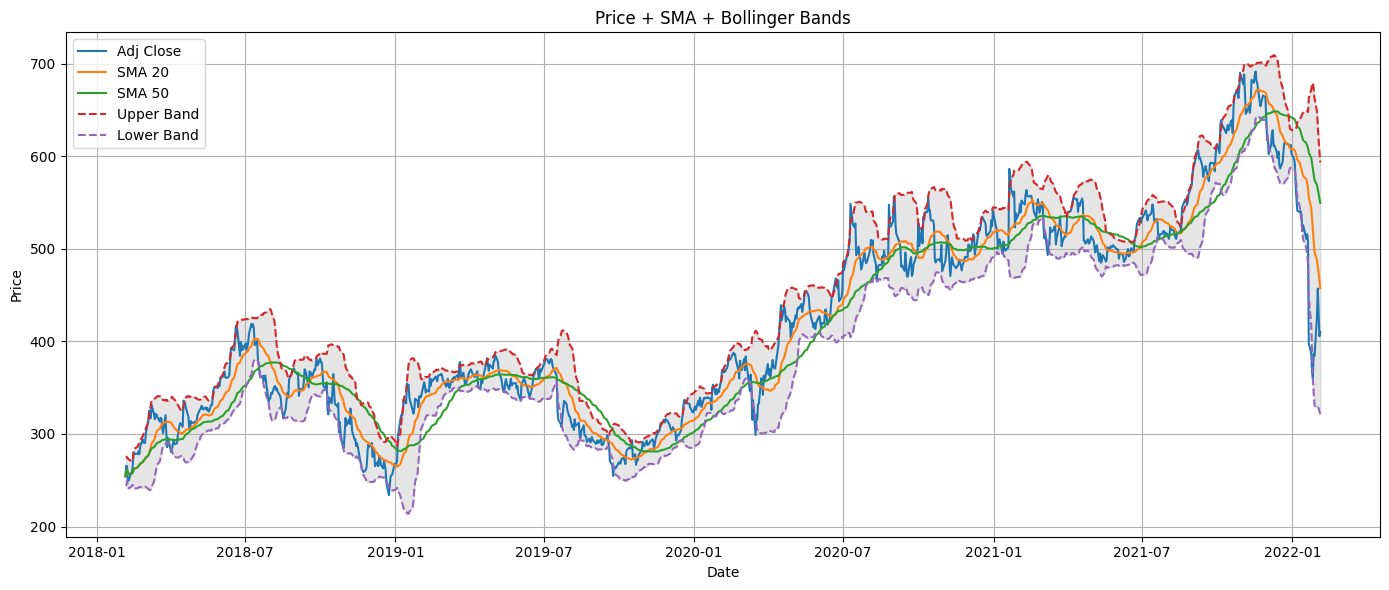

In [142]:
plt.figure(figsize=(14, 6))
plt.plot(plot_df["Date"], plot_df["Adj Close"], label="Adj Close")
plt.plot(plot_df["Date"], plot_df["SMA_20"], label="SMA 20")
plt.plot(plot_df["Date"], plot_df["SMA_50"], label="SMA 50")
plt.plot(plot_df["Date"], plot_df["Upper_Band"], label="Upper Band", linestyle="--")
plt.plot(plot_df["Date"], plot_df["Lower_Band"], label="Lower Band", linestyle="--")
plt.fill_between(plot_df["Date"], plot_df["Lower_Band"], plot_df["Upper_Band"], color='gray', alpha=0.2)
plt.title("Price + SMA + Bollinger Bands")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Plot: RSI

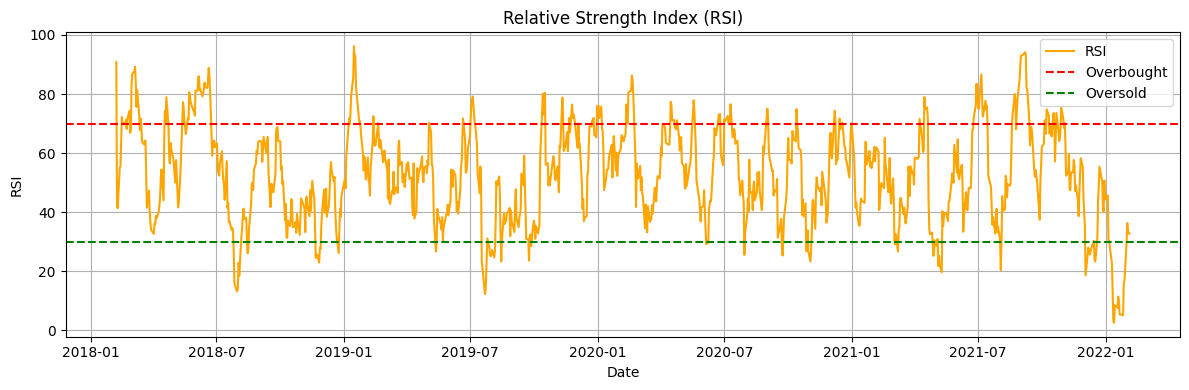

In [143]:
plt.figure(figsize=(12, 4))
plt.plot(plot_df["Date"], plot_df["RSI"], label="RSI", color="orange")
plt.axhline(70, color="red", linestyle="--", label="Overbought")
plt.axhline(30, color="green", linestyle="--", label="Oversold")
plt.title("Relative Strength Index (RSI)")
plt.xlabel("Date")
plt.ylabel("RSI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Plot: SO

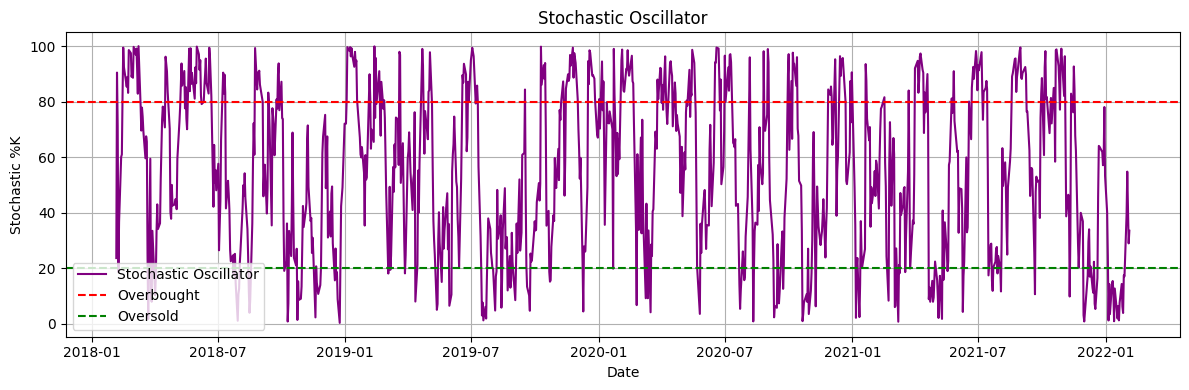

In [144]:
plt.figure(figsize=(12, 4))
plt.plot(plot_df["Date"], plot_df["Stochastic"], label="Stochastic Oscillator", color="purple")
plt.axhline(80, color="red", linestyle="--", label="Overbought")
plt.axhline(20, color="green", linestyle="--", label="Oversold")
plt.title("Stochastic Oscillator")
plt.xlabel("Date")
plt.ylabel("Stochastic %K")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. LSTM

## Setup

In [145]:
pf = plot_df[["Date", "Adj Close"]]

## Implement LSTM memory window

In [146]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(pf[["Adj Close"]])

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

window_size = 20
X, y = create_sequences(scaled_data, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))

## LSTM

In [147]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0519
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0057
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0034
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0035
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0035
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0033
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0035
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0027
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0026
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0030
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0027
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0030
Epoch 13/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0026
Epoch 14/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0031
Epoch 15/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - lo

## Plot the result.

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


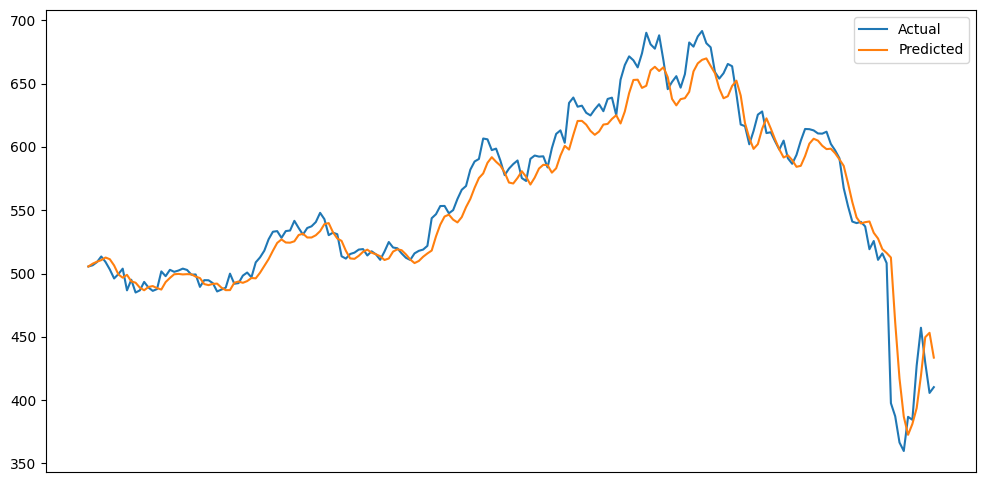

In [ ]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.gca().axes.get_xaxis().set_visible(False)
plt.plot(y_test_rescaled, label="Actual")
plt.plot(y_pred_rescaled, label="Predicted")
plt.legend()
plt.show()